In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from subject_clf.dataset_imperial import dataset, subjects, short_term_weights_path
from subject_clf.subject_net import SubjectNet
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import itertools

In [2]:
num_joints = dataset.skeleton().num_joints()
prefix_length = 50

sn = SubjectNet(num_joints, len(dataset.subjects()), prefix_length, short_term_weights_path)

In [3]:
subject_weights_path = 'weights_subject.bin'
sn.load_weights(subject_weights_path)
sn.eval()

Loading weights from weights_subject.bin


SubjectNet(
  (qn): QuaterNet(
    (rnn): GRU(108, 1000, num_layers=2, batch_first=True)
    (fc): Linear(in_features=1000, out_features=108, bias=True)
  )
  (model): Sequential(
    (0): LeakyReLU(negative_slope=0.05)
    (1): Linear(in_features=1000, out_features=256, bias=True)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=26, bias=True)
    (5): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [4]:
dat = torch.from_numpy(dataset['Subject16']['walking_2_d0']['rotations'][200:250]).reshape(50, -1).float().unsqueeze(0)

In [5]:
id_to_subject = {}
for sid, subject in enumerate(dataset.subjects()):
    id_to_subject[sid] = subject
id_to_subject

{0: 'Subject1',
 1: 'Subject2',
 2: 'Subject3',
 3: 'Subject4',
 4: 'Subject5',
 5: 'Subject6',
 6: 'Subject7',
 7: 'Subject8',
 8: 'Subject9',
 9: 'Subject10',
 10: 'Subject11',
 11: 'Subject12',
 12: 'Subject13',
 13: 'Subject14',
 14: 'Subject15',
 15: 'Subject16',
 16: 'Subject17',
 17: 'Subject18',
 18: 'Subject19',
 19: 'Subject20',
 20: 'Subject21',
 21: 'Subject22',
 22: 'Subject23',
 23: 'Subject24',
 24: 'Subject25',
 25: 'Subject26'}

In [6]:
dat.dtype

torch.float32

In [7]:
with torch.no_grad():
    print(id_to_subject[sn(dat).softmax(dim=1).argmax().item()])

Subject16


In [8]:
h_size = 1000
n_try = 50
subjects = ['Subject1', 'Subject5', 'Subject6', 'Subject8']
H = np.zeros((h_size, n_try*len(subjects)))
for si, s in enumerate(subjects):
    print(s)
    for t in range(n_try):
        i = t + n_try*si
        action = 'walking_2_d%d' % np.random.randint(2)
        data = dataset[s][action]['rotations']
        start_idx = np.random.randint(data.shape[0] - 50)
        chunk = torch.from_numpy(data[start_idx:(start_idx+50)])\
            .reshape(50, -1).float().unsqueeze(0)
        with torch.no_grad():
            H[:,i] = sn.qn(chunk)[1][1]
print('Done')

Subject1
Subject5
Subject6
Subject8
Done


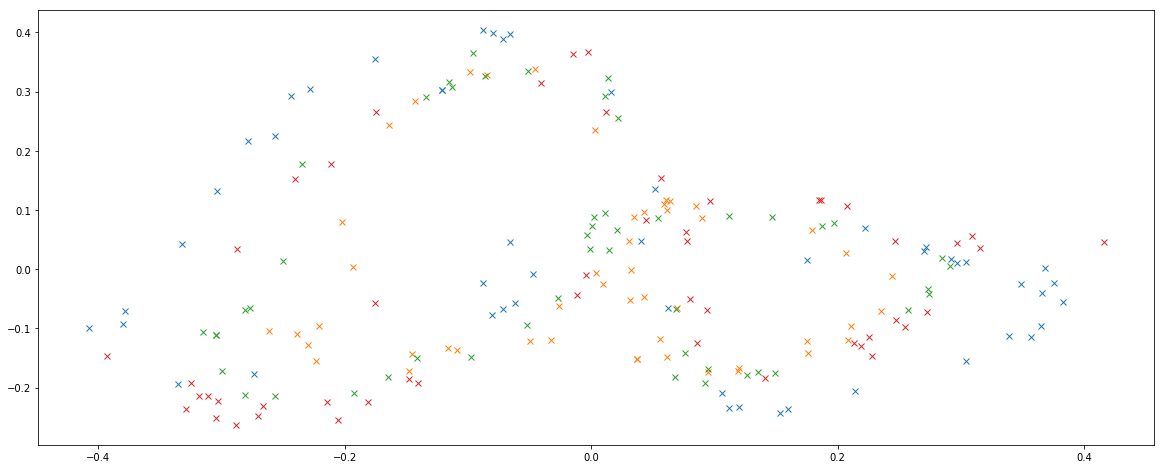

In [9]:
pca = PCA(2)
H_pca = pca.fit_transform(H.T)

plt.figure(figsize=(20,8))
for i in range(len(subjects)):
    plt.plot(H_pca[(n_try*i):(n_try*(i+1)),0], H_pca[(n_try*i):(n_try*(i+1)),1], 'x')

In [ ]:
H_pca.shape

In [11]:
h_size = 1000
n_try = 100
subjects = list(dataset.subjects())
prefix_length = 50

H = np.zeros((h_size, n_try*len(subjects)))
for si, subject in enumerate(subjects):
    print(subject)
    action = 'walking_1_d%d' % (np.random.randint(1))
    data = dataset[subject][action]['rotations']
    start_idx_subject = np.random.randint(data.shape[0] - n_try - prefix_length)
    for t in range(n_try):
        i = t + n_try*si
        start_idx = t + start_idx_subject
        chunk = torch.from_numpy(data[start_idx:(start_idx+prefix_length)])\
            .reshape(prefix_length, -1).float().unsqueeze(0)
        with torch.no_grad():
            H[:,i] = sn.qn(chunk)[1][1]
print('Done')

Subject1
Subject2
Subject3
Subject4
Subject5
Subject6
Subject7
Subject8
Subject9
Subject10
Subject11
Subject12
Subject13
Subject14
Subject15
Subject16
Subject17
Subject18
Subject19
Subject20
Subject21
Subject22
Subject23
Subject24
Subject25
Subject26
Done


<IPython.core.display.Javascript object>


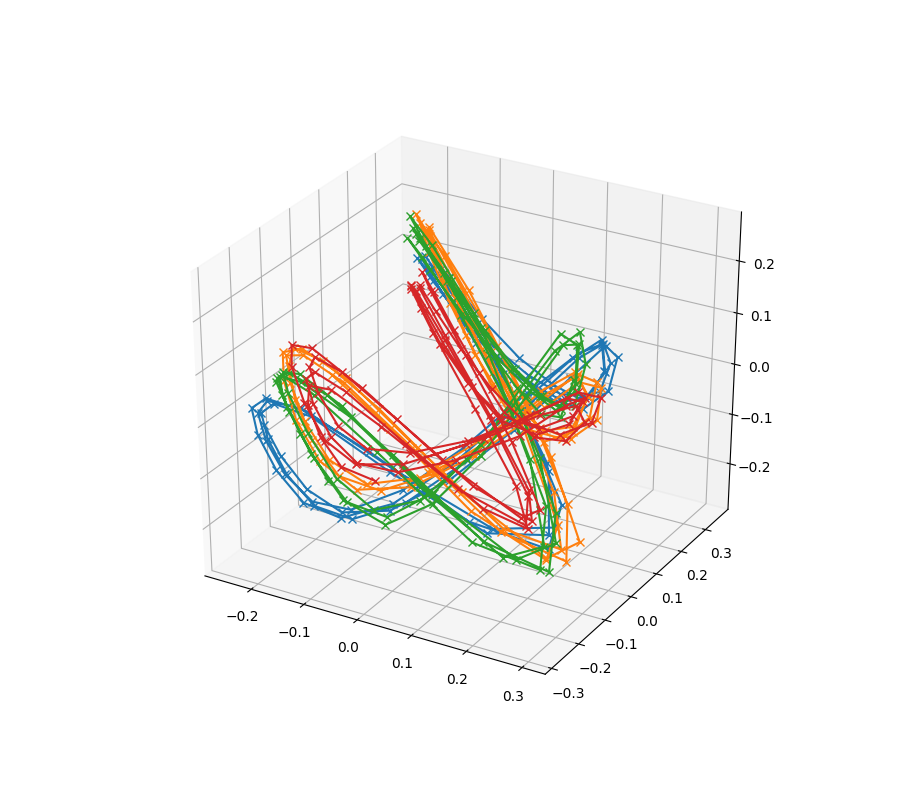

In [175]:
pca = PCA(3)
H_pca = pca.fit_transform(H.T)

%matplotlib notebook
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
for i in [0,5,11,22]:
    plt.plot(H_pca[(n_try*i):(n_try*(i+1)),0], H_pca[(n_try*i):(n_try*(i+1)),1], H_pca[(n_try*i):(n_try*(i+1)),2], 'x-')

In [13]:
np.cumsum(pca.explained_variance_ratio_)

array([0.14513342, 0.27841386, 0.37344562, 0.4463966 , 0.50622897,
       0.54713487, 0.58073829, 0.61247378, 0.63730486, 0.65848074])

<IPython.core.display.Javascript object>


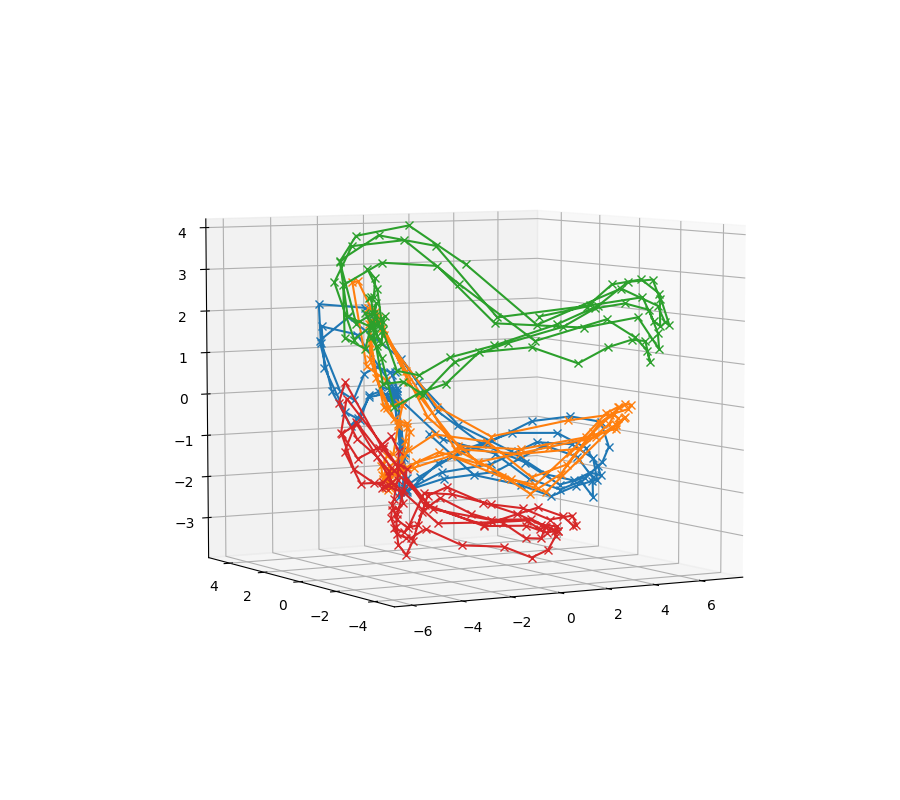

In [168]:
H_nn = sn.model[:3](torch.from_numpy(H.T).cuda().float())
pca = PCA(10)
H_pca = pca.fit_transform(H_nn.detach().cpu().numpy())

%matplotlib notebook
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
for i in [0,5,11,22]:
    plt.plot(H_pca[(n_try*i):(n_try*(i+1)),0], H_pca[(n_try*i):(n_try*(i+1)),1], H_pca[(n_try*i):(n_try*(i+1)),2], 'x-')

In [15]:
np.cumsum(pca.explained_variance_ratio_)

array([0.12671167, 0.21107382, 0.2786094 , 0.31926903, 0.3585308 ,
       0.39599845, 0.42644098, 0.4558437 , 0.48449156, 0.510167  ],
      dtype=float32)

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,3))
plt.plot(H_pca[:,0])

In [35]:
prefix_length = 50
n_subjects = len(dataset.subjects())
C = np.zeros((n_subjects, n_subjects))

def random_chunks(n_chunks, data):
    out = []
    for i in range(n_chunks):
        start_idx = np.random.randint(data.shape[0] - prefix_length)
        di = torch.from_numpy(data[start_idx:(start_idx+prefix_length)])
        out.append(di.reshape(prefix_length, -1).float().unsqueeze(0))
        
    return torch.cat(out)

n_chunks = 50
for i, s in enumerate(dataset.subjects()):
    print(s)
    with torch.no_grad():
        data = dataset[s]['walking_2_d0']['rotations']
        clf = sn(random_chunks(n_chunks, data)).softmax(dim=1).argmax(dim=1)
        for c in clf:
            C[i,c] += 1
        data = dataset[s]['walking_2_d1']['rotations']
        clf = sn(random_chunks(n_chunks, data)).softmax(dim=1).argmax(dim=1)
        for c in clf:
            C[i,c] += 1
C

Subject1
Subject2
Subject3
Subject4
Subject5
Subject6
Subject7
Subject8
Subject9
Subject10
Subject11
Subject12
Subject13
Subject14
Subject15
Subject16
Subject17
Subject18
Subject19
Subject20
Subject21
Subject22
Subject23
Subject24
Subject25
Subject26


array([[100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,  99.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,  

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        lbl = format(cm[i, j], fmt)
        plt.text(j, i, lbl,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.99 0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.  

<IPython.core.display.Javascript object>


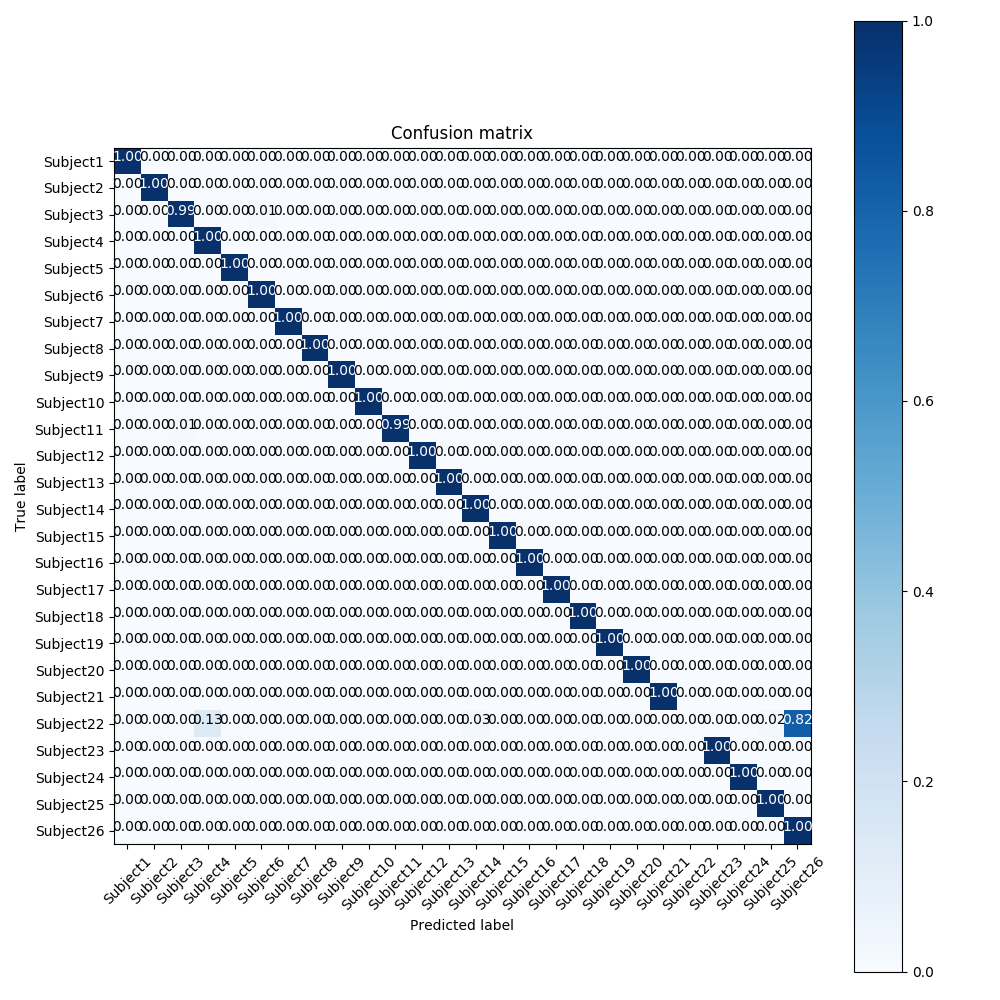

In [36]:
plot_confusion_matrix(C, dataset.subjects(), normalize=True, cmap=plt.cm.Blues)

In [4]:
from common.visualization import render_animation, render_animation_dual

In [4]:
from long_term.dataset_imperial import dataset, long_term_weights_path
from long_term.locomotion_utils import build_extra_features, compute_splines
from long_term.pose_network_long_term import  PoseNetworkLongTerm
from common.spline import Spline
from common.visualization import render_animation, render_animation_dual

if torch.cuda.is_available():
    dataset.cuda()
dataset.compute_euler_angles('yzx')
dataset.compute_positions()
build_extra_features(dataset)

In [5]:
from long_term.pace_network import PaceNetwork

traj = np.array([[-i*0.1,0] for i in range(1737)])
pace_net = PaceNetwork()
pace_net.load_weights('weights_pace_network.bin')
spline = Spline(traj, closed=False)

Loading weights from weights_pace_network.bin


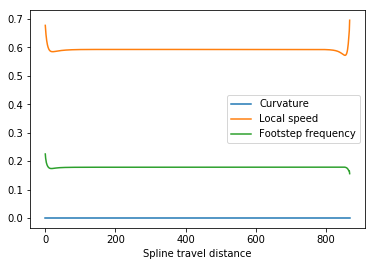

In [6]:
# We want the character to walk
%matplotlib inline
spline_walk = pace_net.predict(spline, average_speed=0.5)
plt.plot(spline_walk.get_track('curvature'))
plt.plot(spline_walk.get_track('amplitude'))
plt.plot(spline_walk.get_track('frequency'))
plt.legend(['Curvature', 'Local speed', 'Footstep frequency'])
_ = plt.xlabel('Spline travel distance')

In [263]:
model = PoseNetworkLongTerm(32, dataset.skeleton())
if torch.cuda.is_available():
    model.cuda()
model.load_weights('weights_long_term.bin') # Load pretrained model

# parameters: 9545250
Loading weights from weights_long_term.bin


In [7]:
dirs

[]

In [8]:
dirs = spline_walk.tracks['direction'][0]
dirs[:,0] = 1
dirs[:,1] = 1
spline_walk.tracks['direction'] = (dirs, 'linear')

In [9]:
%matplotlib notebook
prediction, rotations = model.generate_motion(spline_walk, dataset['Subject26']['walking_1_d0'])
anim = render_animation_dual(prediction, dataset.skeleton(), dataset.fps(), output='interactive')

292 frames generated in 0.415 seconds (702.94 FPS)


TypeError: render_animation_dual() missing 1 required positional argument: 'fps'

In [159]:
_, rotations01 = model.generate_motion(spline_walk, dataset['Subject1']['walking_1_d0'])
_, rotations06 = model.generate_motion(spline_walk, dataset['Subject6']['walking_1_d0'])
_, rotations17 = model.generate_motion(spline_walk, dataset['Subject17']['walking_1_d0'])
_, rotations23 = model.generate_motion(spline_walk, dataset['Subject23']['walking_1_d0'])

292 frames generated in 0.413 seconds (706.18 FPS)
292 frames generated in 0.406 seconds (718.73 FPS)
292 frames generated in 0.418 seconds (699.24 FPS)
292 frames generated in 0.430 seconds (678.97 FPS)


In [116]:
prefix_length = 50
n_subjects = len(dataset.subjects())
C = np.zeros((n_subjects, n_subjects))

def random_chunks(n_chunks, data):
    out = []
    for i in range(n_chunks):
        start_idx = np.random.randint(data.shape[0] - prefix_length)
        di = data[start_idx:(start_idx+prefix_length)]
        out.append(di.reshape(prefix_length, -1).float().unsqueeze(0).cpu())
        
    return torch.cat(out)

n_chunks = 50
for i, s in enumerate(dataset.subjects()):
    with torch.no_grad():
        print(s)
        _, rotations = model.generate_motion(spline_walk, dataset[s]['walking_1_d0'])
        rotations = rotations.squeeze()
        clf = sn(random_chunks(n_chunks, rotations).cuda()).softmax(dim=1).argmax(dim=1)
        for c in clf:
            C[i,c] += 1
        print(C[i,:])
C

Subject1
2927 frames generated in 2.984 seconds (981.04 FPS)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. 50.]
Subject2
2927 frames generated in 2.940 seconds (995.63 FPS)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. 50.]
Subject3


KeyboardInterrupt: 

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.  ]
 [0.8  0.   0.   0.   0.2  0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]
 [0.82 0.   0.   0.   0.18 0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]]


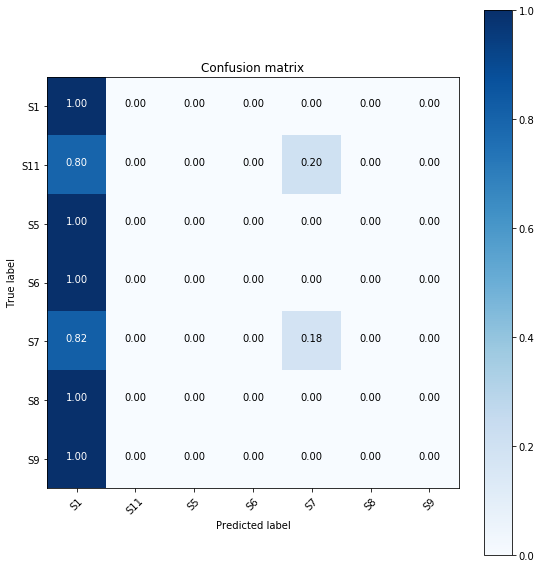

In [104]:
%matplotlib inline
plot_confusion_matrix(C, dataset.subjects(), normalize=True, cmap=plt.cm.Blues)

In [42]:
h.shape

torch.Size([1, 1000])

In [117]:
rot = rotations.squeeze()
sn.cuda()
prefix_length = 50
H_gen = np.zeros((h_size, rot.shape[0] - 100 - prefix_length))
for i, start_idx in enumerate(range(100,rot.shape[0]-prefix_length)):
    chunk = rot[start_idx:(start_idx+prefix_length)].reshape(prefix_length, -1).float().unsqueeze(0)
    with torch.no_grad():
        H_gen[:,i] = sn.qn(chunk)[1][1]


In [160]:
rot = rotations01.squeeze()
sn.cuda()
prefix_length = 50
H_gen01 = np.zeros((h_size, rot.shape[0] - 100 - prefix_length))
for i, start_idx in enumerate(range(100,rot.shape[0]-prefix_length)):
    chunk = rot[start_idx:(start_idx+prefix_length)].reshape(prefix_length, -1).float().unsqueeze(0)
    with torch.no_grad():
        H_gen01[:,i] = sn.qn(chunk)[1][1]
        
rot = rotations06.squeeze()
H_gen06 = np.zeros((h_size, rot.shape[0] - 100 - prefix_length))
for i, start_idx in enumerate(range(100,rot.shape[0]-prefix_length)):
    chunk = rot[start_idx:(start_idx+prefix_length)].reshape(prefix_length, -1).float().unsqueeze(0)
    with torch.no_grad():
        H_gen06[:,i] = sn.qn(chunk)[1][1]
        
rot = rotations17.squeeze()
H_gen17 = np.zeros((h_size, rot.shape[0] - 100 - prefix_length))
for i, start_idx in enumerate(range(100,rot.shape[0]-prefix_length)):
    chunk = rot[start_idx:(start_idx+prefix_length)].reshape(prefix_length, -1).float().unsqueeze(0)
    with torch.no_grad():
        H_gen17[:,i] = sn.qn(chunk)[1][1]
        
rot = rotations23.squeeze()
H_gen23 = np.zeros((h_size, rot.shape[0] - 100 - prefix_length))
for i, start_idx in enumerate(range(100,rot.shape[0]-prefix_length)):
    chunk = rot[start_idx:(start_idx+prefix_length)].reshape(prefix_length, -1).float().unsqueeze(0)
    with torch.no_grad():
        H_gen23[:,i] = sn.qn(chunk)[1][1]

In [209]:
H_gen01/np.linalg.norm(H_gen01, axis=0)

array([[ 5.01298874e-02,  5.75356482e-02,  4.29187679e-02, ...,
        -1.60195099e-05, -2.71260673e-02, -1.38175101e-02],
       [-2.06117539e-02, -2.72103874e-02, -3.49073237e-02, ...,
         3.24708174e-04,  3.83436025e-02, -6.29410017e-03],
       [-3.42625092e-02, -3.71846135e-02, -2.80097760e-02, ...,
        -4.13686698e-03,  8.72656524e-03, -6.77414272e-03],
       ...,
       [ 1.72322647e-02,  1.55658833e-02,  2.84855946e-02, ...,
         4.41955912e-02,  5.06786835e-02,  3.65343954e-02],
       [ 4.97213761e-02,  3.66621402e-02,  4.25396278e-02, ...,
         2.82959628e-02,  3.32655848e-02,  3.49820627e-02],
       [-6.68518664e-03, -1.04590841e-02, -1.35365633e-02, ...,
        -4.49522157e-02, -3.86903212e-02, -4.54544013e-02]])

<IPython.core.display.Javascript object>


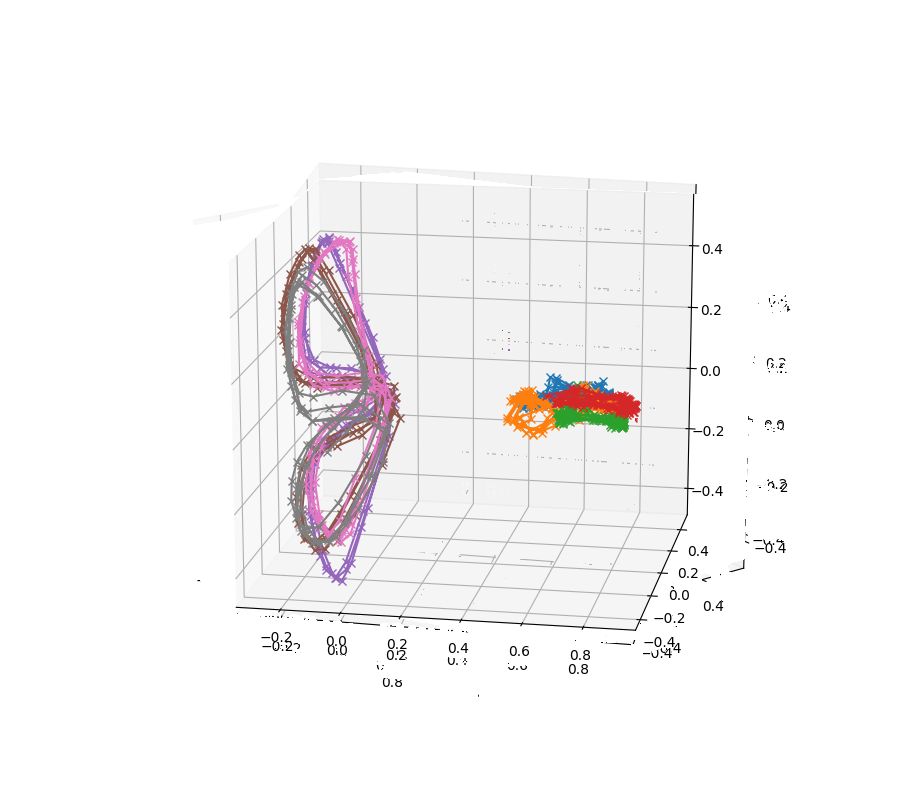

In [222]:
H_all = np.hstack([
    H_gen01,
    H_gen06,
    H_gen17,
    H_gen23,
    H
])
H_all /= np.linalg.norm(H_all,axis=0)

H_all_pca = pca.fit_transform(H_all.T)

%matplotlib notebook
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
for i in range(4):
    plt.plot(H_all_pca[i*142:(i+1)*142,0],H_all_pca[i*142:(i+1)*142,1],H_all_pca[i*142:(i+1)*142,2],'-x')

for i in [0,5,11,22]:
    plt.plot(H_all_pca[(4*142+n_try*i):(4*142+n_try*(i+1)),0],
             H_all_pca[(4*142+n_try*i):(4*142+n_try*(i+1)),1],
             H_all_pca[(4*142+n_try*i):(4*142+n_try*(i+1)),2], 'x-')

<IPython.core.display.Javascript object>


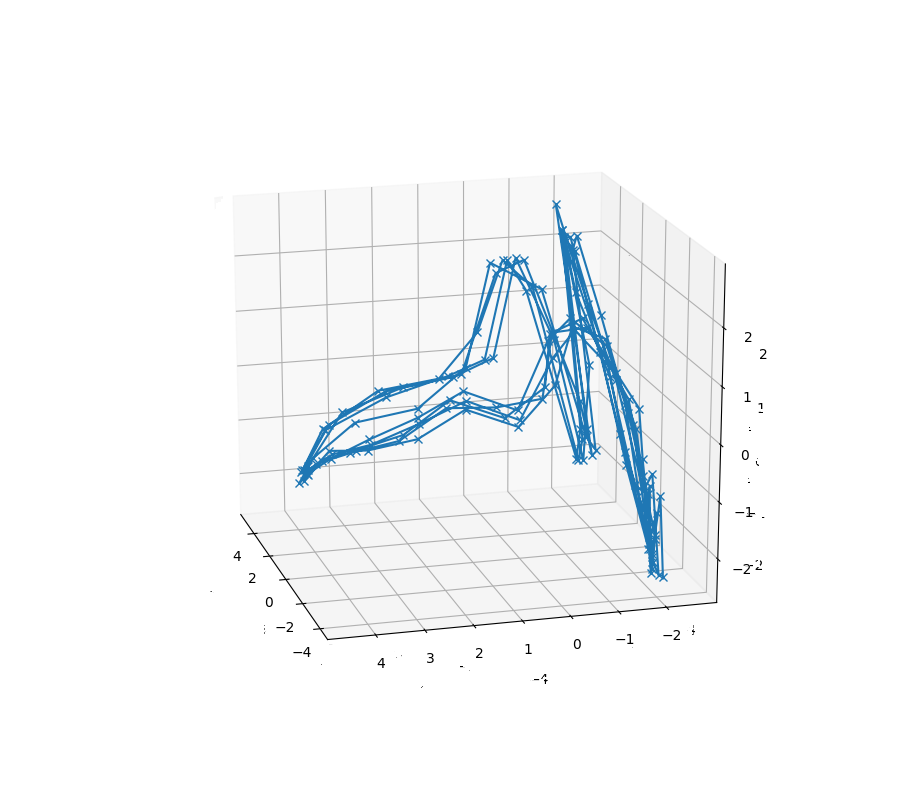

In [177]:
H_gen_pca01 = pca.fit_transform(H_gen01.T)

%matplotlib notebook
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
plt.plot(H_gen_pca01[:,0],H_gen_pca01[:,1],H_gen_pca01[:,2],'-x')

<IPython.core.display.Javascript object>


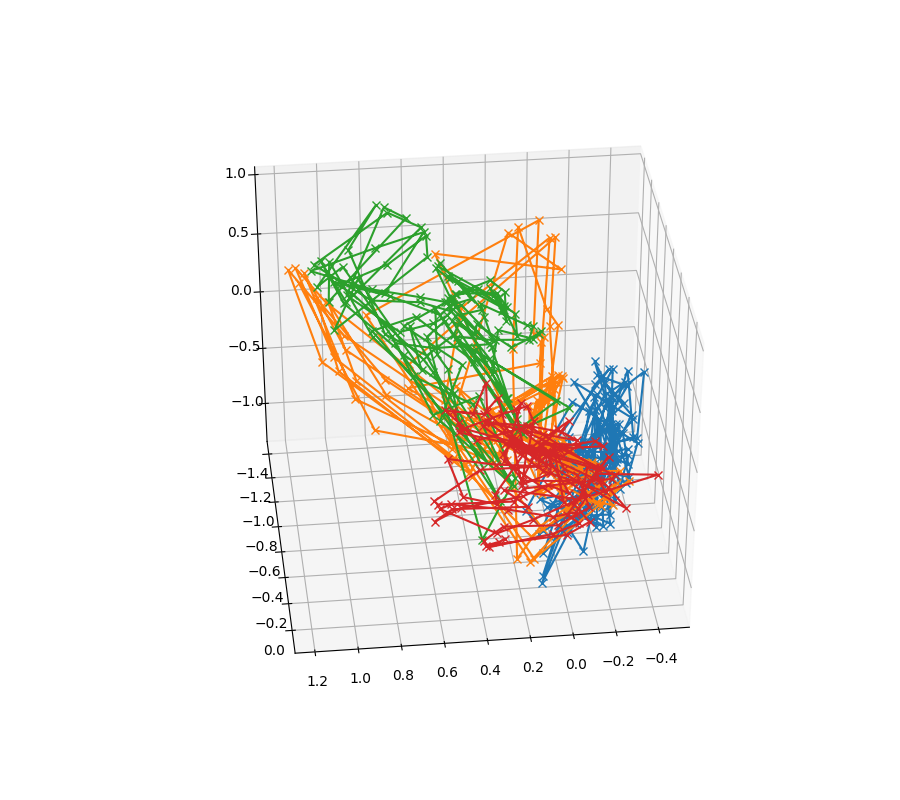

In [176]:
H_gen_pca01 = pca.transform(H_gen01.T)
H_gen_pca06 = pca.transform(H_gen06.T)
H_gen_pca17 = pca.transform(H_gen17.T)
H_gen_pca23 = pca.transform(H_gen23.T)

%matplotlib notebook
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
plt.plot(H_gen_pca01[:,0],H_gen_pca01[:,1],H_gen_pca01[:,2],'-x')
plt.plot(H_gen_pca06[:,0],H_gen_pca06[:,1],H_gen_pca06[:,2],'-x')
plt.plot(H_gen_pca17[:,0],H_gen_pca17[:,1],H_gen_pca17[:,2],'-x')
plt.plot(H_gen_pca23[:,0],H_gen_pca23[:,1],H_gen_pca23[:,2],'-x')

<IPython.core.display.Javascript object>


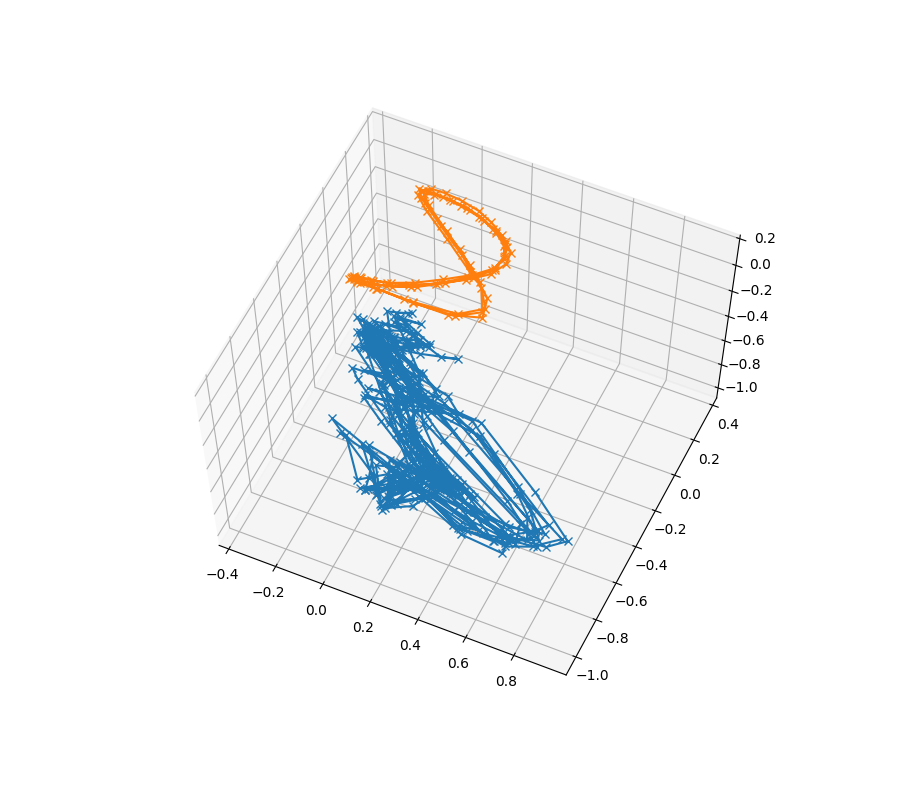

In [124]:
H_gen_pca = pca.transform(H_gen.T)

%matplotlib notebook
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
plt.plot(H_gen_pca[200:600,0],H_gen_pca[200:600,1],H_gen_pca[200:600,2],'-x')

In [10]:
spline_walk.tracks['direction'][:,0] = 0
spline_walk.tracks['direction'][:,0] = 1

TypeError: 'tuple' object does not support item assignment

1684 frames generated in 1.683 seconds (1000.56 FPS)


<IPython.core.display.Javascript object>


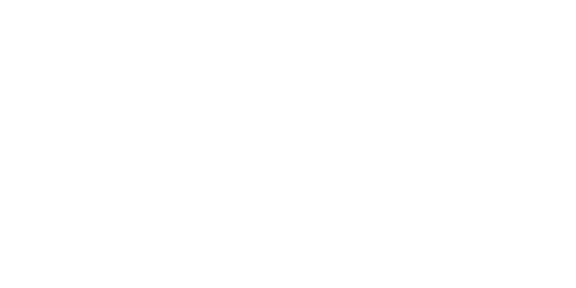

<IPython.core.display.Javascript object>


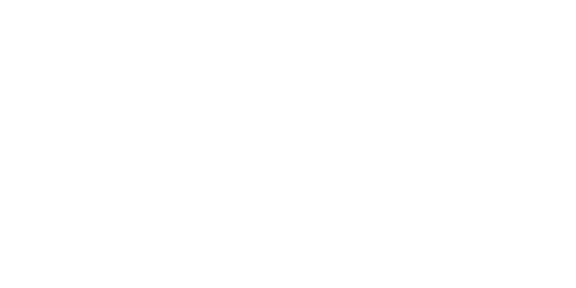

Traceback (most recent call last):
  File "/zhome/9d/d/98006/Documents/derp-project/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/zhome/9d/d/98006/Documents/derp-project/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/zhome/9d/d/98006/Documents/derp-project/lib/python3.6/site-packages/matplotlib/backends/backend_nbagg.py", line 241, in <lambda>
    canvas.mpl_connect('close_event', lambda event: Gcf.destroy(num))
  File "/zhome/9d/d/98006/Documents/derp-project/lib/python3.6/site-packages/matplotlib/_pylab_helpers.py", line 58, in destroy
    cls._activeQue.remove(manager)
ValueError: list.remove(x): x not in list


In [262]:
traj = np.array([[i,0] for i in range(1000)])
spline = Spline(traj, closed=False)
spline_walk = pace_net.predict(spline, average_speed=0.5)

spline_walk.tracks['direction'][0][:,0] = 1
spline_walk.tracks['direction'][0][:,1] = 1

%matplotlib notebook
prediction, rotations = model.generate_motion(spline_walk, dataset['Subject15']['walking_2_d1'])
anim = render_animation_dual(prediction, 
                             dataset['Subject15']['walking_2_d1']['positions_world'][model.prefix_length:], 
                             dataset.skeleton(), dataset.fps(), output='interactive')

In [192]:
fft_gen.shape

(401, 81)

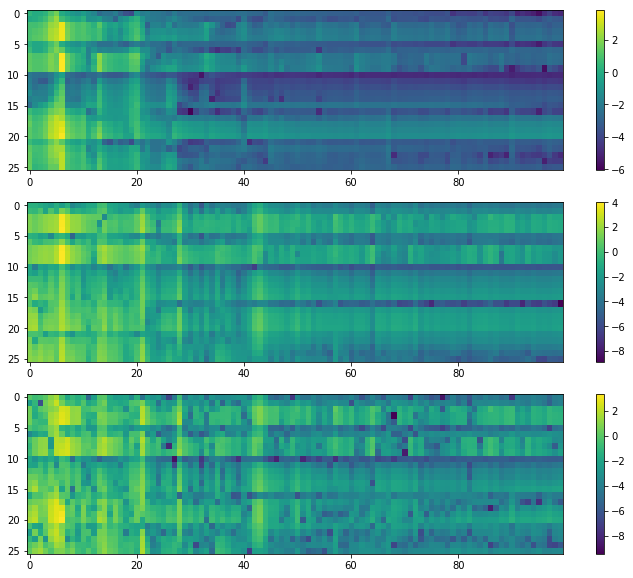

In [307]:
npt = 200
chunk_gen = prediction.reshape(-1,27*3)[:npt]
chunk_dat = dataset['Subject18']['walking_2_d0']['positions_world'][model.prefix_length:model.prefix_length+npt].reshape(-1,27*3)
fft_gen = np.fft.rfft(chunk_gen, axis=0)
fft_dat = np.fft.rfft(chunk_dat, axis=0)
freqs = np.fft.rfftfreq(npt, 1/dataset.fps())

%matplotlib inline
plt.figure(figsize=(12,10))
#plt.plot(freqs[1:], np.mean(np.abs(fft_dat[1:,::3]),axis=1))
#plt.plot(freqs[1:], np.mean(np.abs(fft_gen[1:,::3]),axis=1))
#plt.plot(np.real(fft_dat[1:,4]), np.imag(fft_dat[1:,12]),'.')
#plt.plot(np.real(fft_gen[1:,4]), np.imag(fft_gen[1:,5]),'.')


plt.subplot(311)
plt.imshow(np.log(np.abs(fft_gen[1:,3::3].T)), aspect='auto')
plt.colorbar()

plt.subplot(312)
plt.imshow(np.log(np.abs(fft_dat[1:,3::3].T)), aspect='auto')
plt.colorbar()

plt.subplot(313)
plt.imshow(np.log(np.abs(np.abs(fft_dat[1:,3::3].T) - np.abs(fft_gen[1:,3::3].T))), aspect='auto')
plt.colorbar()


In [244]:
%matplotlib inline
np.sum(np.sqrt(np.sum(100*(np.log10(np.abs(fft_gen[:,3:])/np.abs(fft_dat[:,3:]))**2), axis=0)))

9722.38496350613

In [245]:
def logspecdist(spec1, spec2):
    return np.sum(np.sqrt(np.sum(100*(np.log10(np.abs(spec1)/np.abs(spec2))**2), axis=0)))

In [250]:
fft_dat[:,3:].shape

(401, 78)

In [264]:
nsubject = len(dataset.subjects())
npt = 800
D = np.zeros((2*nsubject,2*nsubject))
for i, s1 in enumerate(dataset.subjects()):
    print('%d / %d' % (i+1, nsubject))
    
    pred1 = model.generate_motion(spline_walk, dataset[s1]['walking_2_d0'], do_print=False)[0]
    chunk_gen1 = pred1.reshape(-1,27*3)[:npt]
    chunk_dat1 = dataset[s1]['walking_2_d0']['positions_world'][model.prefix_length:model.prefix_length+npt].reshape(-1,27*3)
    fft_gen1 = np.fft.rfft(chunk_gen1[:,3:], axis=0)
    fft_dat1 = np.fft.rfft(chunk_dat1[:,3:], axis=0)
    
    for j, s2 in enumerate(dataset.subjects()):
        pred2 = model.generate_motion(spline_walk, dataset[s2]['walking_2_d0'], do_print=False)[0]
        chunk_gen2 = pred2.reshape(-1,27*3)[:npt]
        chunk_dat2 = dataset[s2]['walking_2_d0']['positions_world'][model.prefix_length:model.prefix_length+npt].reshape(-1,27*3)
        fft_gen2 = np.fft.rfft(chunk_gen2[:,3:], axis=0)
        fft_dat2 = np.fft.rfft(chunk_dat2[:,3:], axis=0)
        D[i,j] = logspecdist(fft_dat1, fft_dat2)
        D[i,j+nsubject] = logspecdist(fft_dat1, fft_gen2)
        D[i+nsubject,j] = logspecdist(fft_gen1, fft_dat2)
        D[i+nsubject,j+nsubject] = logspecdist(fft_gen1, fft_gen2)

1 / 26
2 / 26
3 / 26
4 / 26
5 / 26
6 / 26
7 / 26
8 / 26
9 / 26
10 / 26
11 / 26
12 / 26
13 / 26
14 / 26
15 / 26
16 / 26
17 / 26
18 / 26
19 / 26
20 / 26
21 / 26
22 / 26
23 / 26
24 / 26
25 / 26
26 / 26


In [272]:
Dp.shape

(52, 52)

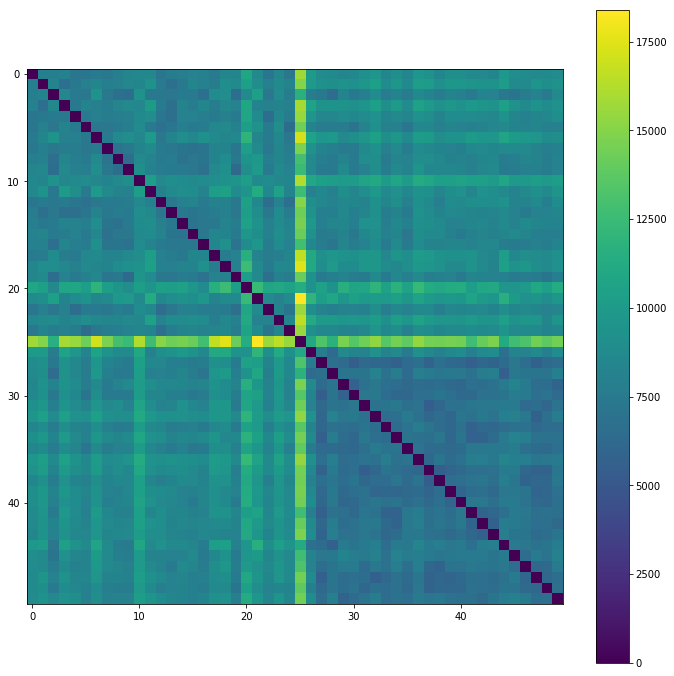

In [279]:
Dp = D
to_remove = np.array([15])
Dp = np.delete(Dp, nsubject+to_remove, 1)
Dp = np.delete(Dp, to_remove, 1)
Dp = np.delete(Dp, nsubject+to_remove, 0)
Dp = np.delete(Dp, to_remove, 0)

%matplotlib inline
plt.figure(figsize=(12,12))
plt.imshow(Dp)
plt.colorbar()

<IPython.core.display.Javascript object>


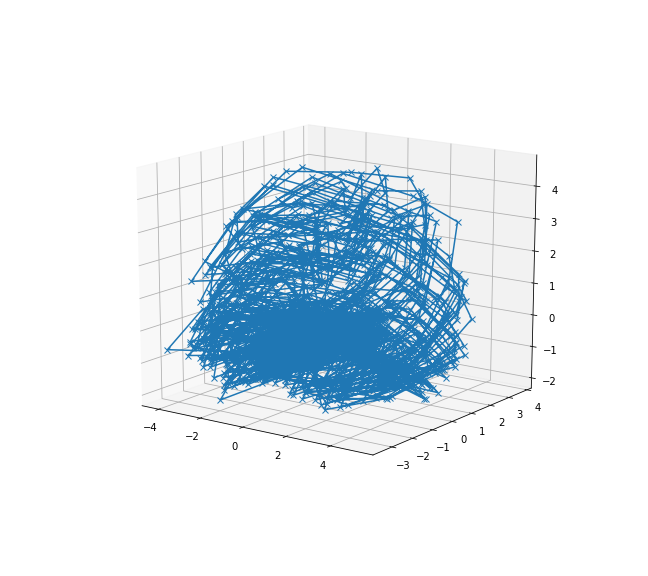

In [137]:
pca = PCA(3)
H = np.vstack((H_real, H_pred))

H_pca = pca.fit_transform(H_pred)

%matplotlib notebook
fig = plt.figure(figsize=(9,8))
ax = fig.add_subplot(111, projection='3d')
plt.plot(H_pca[:num_frames,0],H_pca[:num_frames,1],H_pca[:num_frames,2],'-x')
#plt.plot(H_pca[num_frames:,0],H_pca[num_frames:,1],H_pca[num_frames:,2],'-x')

<IPython.core.display.Javascript object>


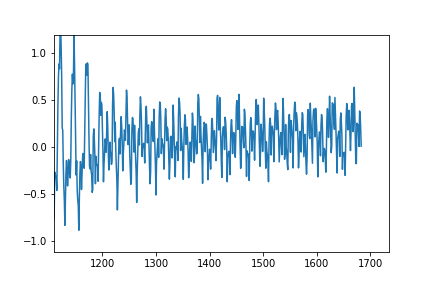

In [139]:
plt.figure()
plt.plot(H_pca[:num_frames,0])

<IPython.core.display.Javascript object>


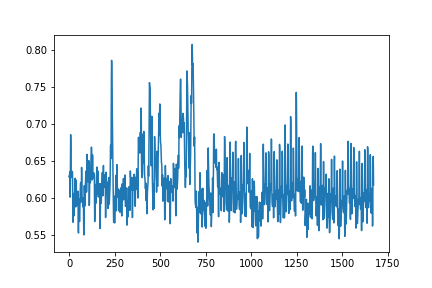

In [124]:
plt.figure()
plt.plot(np.linalg.norm(H_real[10:,:],axis=1))